In machine learning, the train-dev-test split is a common technique used to evaluate the performance of a model and prevent overfitting. The dataset is divided into three subsets: the training set, the development (or validation) set, and the test set.

The benchmark comprises 8628 sentence pairs. This is the breakdown according to genres and train-dev-test splits:

                train  dev test total 
        -----------------------------
        news     3299  500  500  4299
        caption  2000  625  525  3250
        forum     450  375  254  1079
        -----------------------------
        total    5749 1500 1379  8628

## Preliminary analysis
- [x] Calculate average document length
- [x] Calculate average vocabulary size
- [x] Calculate average sentence length
- [ ] Check if scores are balanced
- [ ] Topic clustering
- [ ] Keyword search
- [ ] Word2Vec embedding

<input type="checkbox"> Checkbox item 1<br>
<input type="checkbox" disabled> Checkbox item 2<br>
<input type="checkbox" disabled> Checkbox item 3<br>

In [185]:
import pandas as pd
import numpy as np
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from unidecode import unidecode

[nltk_data] Downloading package punkt to /home/fabio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/fabio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [186]:
def on_bad_line(values):
    return values[:7]

columns_mapping = {
    0: 'genre',
    1: 'filename',
    2: 'year',
    3: 'index',
    4: 'score',
    5: 'sentence1',
    6: 'sentence2'
}

# quotings 3 = csv.QUOTE_NONE
df = pd.read_csv('Dataset/sts-train.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'shape of the Dataframe {df.shape}')
df.head(10)

shape of the Dataframe (5749, 7)


,genre,filename,year,index,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.
5,main-captions,MSRvid,2012test,11,4.25,Some men are fighting.,Two men are fighting.
6,main-captions,MSRvid,2012test,12,0.50,A man is smoking.,A man is skating.
7,main-captions,MSRvid,2012test,13,1.60,The man is playing the piano.,The man is playing the guitar.
8,main-captions,MSRvid,2012test,14,2.20,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...
9,main-captions,MSRvid,2012test,16,5.00,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.


In [187]:
sentences1 = df["sentence1"]
sentences2 = df["sentence2"]
sentences_list = np.unique(np.concatenate((np.ravel(sentences1.values),np.ravel(sentences2.values))))

print(f"Total number of sentences: {len(sentences_list)}")

Total number of sentences: 10566


In [220]:
def remove_special_chars(text):
    regex = '[' + punctuation + ']'
    return re.sub(regex,'',unidecode(text)).lower()

def remove_stop_words(text):
    stop_words = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in stop_words])

no_punct_sentences_list = [remove_special_chars(string) for string in sentences_list]
clean_sentences_list = [remove_stop_words(string) for string in no_punct_sentences_list]

print(sentences_list)
print(clean_sentences_list)

[' - Income, top rate:  percent.' ' Foxe was mostly frozen.'
 " billion . Everyone in the world at Mexico's current prosperity level."
 ...
 'zhang yan stated that all countries should abide by non-proliferation obligations in order to enhance mutual trust and create a sound environment for international cooperation in nuclear energy.'
 'zhang yan stated that china opposes using non-proliferation as a pretext for restricting and depriving non-nuclear-weapon states of the right to peaceful use of nuclear energy.'
 '‚ÄėGlee‚Äô star Cory Monteith found dead in hotel room']
['income top rate percent', 'foxe mostly frozen', 'billion everyone world mexicos current prosperity level', 'warmedc year prior', 'americans dont cut run see misadventure said', 'eight 10 seconds hit', 'first blush doesnt look like rules broken said gen richard myers chairman joint chiefs staff', 'nukes mean wanting use nukes', 'using nukes means wanting use nukes', 'biotech products anything may safer conventional pro

In [190]:
array_len = np.vectorize(len)(sentences_list)
mean_len = np.mean(array_len)
print(f"Mean length of sentences in characters: {mean_len:.2f}")

Mean length of sentences in characters: 59.37


Maximum sentence length: 56
Minimum sentence length: 2
Mean length of sentences in words: 10.17


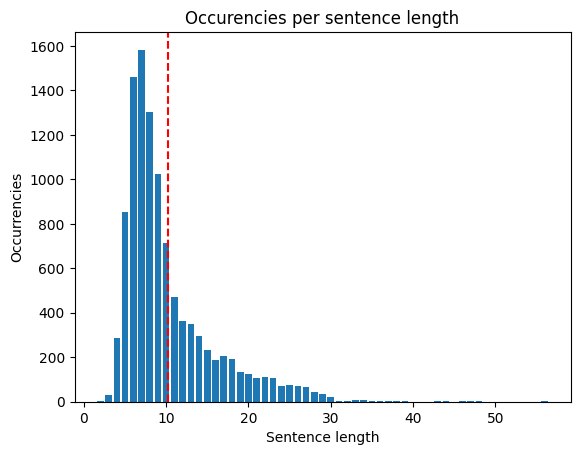

In [191]:
arr_words = np.array([len(s.split()) for s in sentences_list])

print(f"Maximum sentence length: {np.max(arr_words)}")
print(f"Minimum sentence length: {np.min(arr_words)}")

mean_sentences_length = np.mean(arr_words);
print(f"Mean length of sentences in words: {mean_sentences_length:.2f}")

unique, counts = np.unique(arr_words, return_counts=True)

plt.bar(unique, counts)

plt.axvline(x=mean_sentences_length, color='r', linestyle='--')

plt.xlabel("Sentence length")
plt.ylabel("Occurrencies")
plt.title("Occurencies per sentence length")


plt.show()

In [192]:
words_with_duplicates = [word for string in no_punct_sentences_list for word in word_tokenize(string)]
words_nostopwords = [w for w in words_with_duplicates if w not in stopwords.words('english')]
counts_nostopwords = nltk.Counter(words_nostopwords)
counts_nostopwords.most_common(20)

[('man', 853),
 ('woman', 547),
 ('two', 458),
 ('said', 455),
 ('dog', 418),
 ('us', 402),
 ('white', 282),
 ('killed', 265),
 ('black', 258),
 ('playing', 254),
 ('percent', 253),
 ('new', 238),
 ('people', 217),
 ('syria', 211),
 ('china', 191),
 ('police', 173),
 ('running', 170),
 ('president', 168),
 ('person', 161),
 ('water', 156)]

In [193]:
vocabulary = np.unique(words_nostopwords)
print(len(vocabulary))
print(vocabulary)

12243
['0' '004' '005' ... 'zubaidi' 'zuccarini' 'zuma']


Mean scores of sentence similarity: 2.70


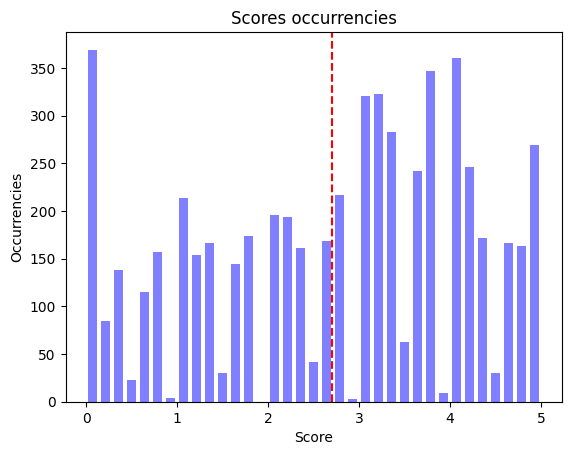

In [194]:
tot_scores = df["score"]
scores = np.ravel(tot_scores.values)

mean_scores = np.mean(scores);
print(f"Mean scores of sentence similarity: {mean_scores:.2f}")

plt.hist(scores, bins=35, alpha=0.5, color='blue', rwidth=0.7)

plt.axvline(x=mean_scores, color='r', linestyle='--')

plt.xlabel("Score")
plt.ylabel("Occurrencies")
plt.title("Scores occurrencies")

plt.show()

## Text Clustering

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
# creazione della matrice di similarità
tfidf = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english', strip_accents='ascii')
tfidf_matrix = tfidf.fit_transform(no_punct_sentences_list)
vocab = tfidf.get_feature_names_out()

print(tfidf_matrix.shape)
print(vocab)

(10566, 2782)
['04' '07' '10' ... 'zimbabwe' 'zimmerman' 'zone']


In [12]:
word = 'dog'
word_id = tfidf.transform([word]).nonzero()[1]
filter = tfidf_matrix.getcol(word_id).nonzero()[0]
print(f'The word {word} is present in {len(filter)} documents. Here\'s the first 5:')
for idx, sentence in enumerate(no_punct_sentences_list[filter][:5]):
    print(str(idx + 1) + '.' , sentence)

The word dog is present in 406 documents. Here's the first 5:
1. a baby is playing with a dog
2. a baby plays with a dog and ball
3. a black and a brown dog running in the grass
4. a black and a yellow dog
5. a black and brown dog runs through the woods


[[1.16756416 1.08627726 1.10761214 ... 1.09864128 1.07390301 1.09546637]
 [1.16756416 1.08145617 1.10761214 ... 1.09864128 1.07390301 1.09546637]
 [1.16756416 1.08471442 1.10761214 ... 1.09864128 1.07390301 1.09546637]
 ...
 [1.16756416 1.08535077 1.10761214 ... 1.09864128 1.07127939 1.09486491]
 [1.16756416 1.08250989 1.10628172 ... 1.09579484 1.06382312 1.09289389]
 [1.16756416 1.08599723 1.10048874 ... 1.09864128 1.07390301 1.09546637]]
[26 18 18 ...  6  6  9]


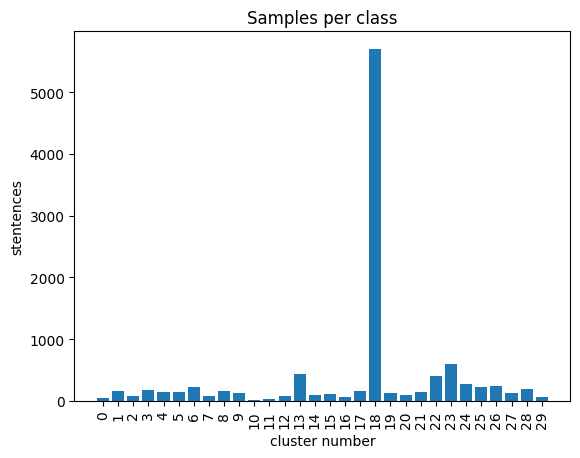

In [13]:
#TODO remove
k = 30
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_matrix = kmeans.fit_transform(tfidf_matrix)
print(cluster_matrix)
clusters = np.argmin(cluster_matrix, axis=-1)
print(clusters)

uniques, counts = np.unique(clusters, return_counts=True)
plt.bar(uniques, counts)
plt.xlabel('cluster number')
plt.ylabel('stentences')
plt.xticks(uniques, rotation=90)
plt.title('Samples per class')
plt.show()

In [14]:
print(no_punct_sentences_list[clusters==2]) #TODO remove

['a macintosh computer sitting on the floor'
 'a baby in a red hat sitting in a stroller is holding a doll'
 'a baby is sitting in the grass'
 'a black and white chair sitting in front of a brick wall and a window with a bamboo plant in a vase'
 'a black woman and two black children are sitting in a thatched tent'
 'a blackbird sitting on the ground'
 'a buddha statue holding a candle is sitting on a table'
 'a bulldog sitting on a yellow chair beside a large waste receptacle'
 'a camouflaged plane sitting on the green grass'
 'a dog sitting on a yellow chair next to a green dumpster'
 'a ginger cat sitting on an office chair'
 'a girl sitting in a living chair'
 'a girl with a black purse sitting on a wooden bench'
 'a guy is sitting on his bike with one wheel in the air'
 'a large black bird is sitting in the water'
 'a man and two women smiling at the camera while sitting on a blue sofa'
 'a man and woman sitting back to back outside in the sun'
 'a man and women sitting on a sofa h

In [16]:
print("Top terms per cluster:")

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:5]]}")

Top terms per cluster:
Cluster 0:	['sheep', 'standing', 'black', 'field', 'hill']
Cluster 1:	['people', 'group', 'table', 'walking', 'dancing']
Cluster 2:	['sitting', 'table', 'people', 'women', 'man']
Cluster 3:	['playing', 'guitar', 'man', 'dogs', 'flute']
Cluster 4:	['girl', 'little', 'young', 'riding', 'horse']
Cluster 5:	['running', 'dog', 'grass', 'dogs', 'brown']
Cluster 6:	['nuclear', 'iran', 'korea', 'north', 'talks']
Cluster 7:	['train', 'tracks', 'station', 'track', 'passenger']
Cluster 8:	['president', 'visit', 'vice', 'sworn', 'state']
Cluster 9:	['dead', 'shooting', 'crash', 'injured', 'train']
Cluster 10:	['shrimp', 'woman', 'peels', 'peeling', 'cleaning']
Cluster 11:	['cross', 'lebanon', 'russians', 'red', 'syria']
Cluster 12:	['red', 'bus', 'decker', 'double', 'street']
Cluster 13:	['woman', 'slicing', 'man', 'riding', 'meat']
Cluster 14:	['standing', 'field', 'man', 'black', 'cow']
Cluster 15:	['death', 'toll', 'rises', 'penalty', 'bangladesh']
Cluster 16:	['cutting',

# Training models

## Bag of Words

We just trained a tf-idf model to compute clusters. We can also use this model to compute similarity between sentences using a bag of words approach.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
import pandas as pd

In [202]:
def train_tfidf_vectorizer(sentences_list, max_df=0.8, min_df=5, remove_stopwords=True, ngram_range=(1,1)):
    """
    Train a TF-IDF vectorizer on the given sentences list.
    
    max_df: ignore terms that appear in more than max_df of the documents
    min_df: ignore terms that appear in less than min_df of the documents
    remove_stopwords: remove stopwords from the sentences
    preprocess_sentence: function to preprocess each sentence
    ngram_range: range of ngrams to consider
    """

    # Define TF-IDF Vectorizer
    tfidf = TfidfVectorizer(
        max_df=max_df, min_df=min_df, 
        stop_words='english' if remove_stopwords else None, 
        strip_accents='ascii',
        ngram_range=ngram_range
    )

    # Fit the vectorizer on the sentences and compute the TF-IDF matrix
    tfidf_matrix = tfidf.fit_transform(sentences_list)
    tfidf_vocab = tfidf.get_feature_names_out()

    # Analyze results
    print(f"The dataset contains {len(tfidf_vocab)} terms")
    np.random.seed(41)
    random_sentence = np.random.choice(sentences_list)
    print("Random sentence:", random_sentence)
    random_sentence_tfidf_scores = tfidf.transform([random_sentence])
    sentence_df = pd.DataFrame({
        "id": random_sentence_tfidf_scores.nonzero()[1],
        "word": tfidf_vocab[random_sentence_tfidf_scores.nonzero()[1]],
        "scores": random_sentence_tfidf_scores.data
    })
    print(sentence_df.head())

    return tfidf, tfidf_matrix

In [203]:
def evaluate_mse(model: TfidfVectorizer, dataset: pd.DataFrame):
    predicted_scores = []
    for idx, row in dataset.iterrows():
        a = row["sentence1"]
        b = row["sentence2"]
        vectorized_sentences = model.transform([a, b])
        similarity = cosine_similarity(vectorized_sentences)
        predicted_scores.append(similarity[0][1])

    return mean_squared_error(dataset["score"].values, predicted_scores)

In [226]:
clean_dataset = pd.DataFrame({
    'sentence1': df['sentence1'].map(remove_special_chars).map(remove_stop_words),
    'sentence2': df['sentence2'].map(remove_special_chars).map(remove_stop_words),
    'score': df['score'] / 5
})

tfidf_vectorizer, tfidf_matrix = train_tfidf_vectorizer(clean_sentences_list, min_df=0)

The dataset contains 12067 terms
Random sentence: person hitchhiking road
     id         word    scores
0  9265         road  0.502688
1  8110       person  0.412441
2  5404  hitchhiking  0.759735


Now we print the most similar sentences of a selected one using cosine similarity, showing the original ones


In [222]:
tfidf_similarity = cosine_similarity(tfidf_matrix)
tfidf_sentence_idx = 10
print(sentences_list[tfidf_sentence_idx])
for i, col_idx in enumerate(tfidf_similarity[tfidf_sentence_idx].argsort()[::-1][1:6]):
    print(str(i+1) + ")",f"{tfidf_similarity[tfidf_sentence_idx][col_idx]:.2f}", sentences_list[col_idx])

"Biotech products, if anything, may be safer than conventional products because of all the testing," said Robert Fraley, Monsanto's executive vice president.
1) 0.69 "Biotech products, if anything, may be safer than conventional products because of all the testing," Fraley said, adding that 18 countries have adopted biotechnology.
2) 0.37 Products featuring Vanderpool will be released within five years, he said.
3) 0.35 As executive vice president of new ventures, Elias will report to Joe Tucci, EMC's president and chief executive.
4) 0.26 Bruce N. Hawthorne, 53, was named executive vice president and chief staff officer.
5) 0.25 Micronesia vice president to visit China


In [225]:
print("MSE:", evaluate_mse(tfidf_vectorizer, clean_dataset))

MSE: 0.05174592726147045


We try to improve it using trigrams

In [228]:
trigrams_tfidf_vectorizer, _ = train_tfidf_vectorizer(clean_sentences_list, ngram_range=(1,3), min_df=2)
print("MSE:", evaluate_mse(trigrams_tfidf_vectorizer, clean_dataset))
#TODO cercare su internet comparazione performance bigrammi monogrammi

The dataset contains 21599 terms
Random sentence: person hitchhiking road
      id    word    scores
0  16397    road  0.773089
1  14211  person  0.634297
MSE: 0.06786084296557404


we try to improve by handling numbers

In [229]:
def substitute_number(sentence):
    return re.sub(r'\d+', ' number ', sentence)

In [231]:
no_number_dataset = pd.DataFrame({
    'sentence1': clean_dataset['sentence1'].map(substitute_number),
    'sentence2': clean_dataset['sentence2'].map(substitute_number),
    'score': clean_dataset['score']
})

#TODO mostrare differenze tra originale e con [number]
no_number_sentences_list = [substitute_number(sentence) for sentence in clean_sentences_list]

number_tfidf_vectorizer, number_tfidf_matrix = train_tfidf_vectorizer(no_number_sentences_list, min_df=0)
print("MSE:", evaluate_mse(number_tfidf_vectorizer, no_number_dataset))

The dataset contains 11250 terms
Random sentence: person hitchhiking road
     id         word    scores
0  8458         road  0.502688
1  7303       person  0.412441
2  4602  hitchhiking  0.759735
MSE: 0.05452352749923701


we try to improve by lemmatizing the sentences

In [ ]:
!pip install -U spacy
import spacy

In [32]:
import sys
!{sys.executable} -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 6.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.2
    Uninstalling spacy-3.5.2:
      Successfully uninstalled spacy-3.5.2


/home/fabio/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-05-17 21:21:10.118497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 21:21:17.153943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-17 21:22:00.234554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


/home/fabio/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-05-17 21:23:03.895916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-17 21:23:45.011369: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
#import en_core_web_sm
import spacy
spacy_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

/home/fabio/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-05-20 09:59:02.780667: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 09:59:06.472144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-20 09:59:33.536118: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [232]:
def lemmatize_sentence(sentence):
    parsed_sentence = spacy_nlp(str(sentence))
    lemmatized_sentence = ' '.join([word.lemma_ for word in parsed_sentence])
    return lemmatized_sentence

lemmatized_dataset = pd.DataFrame({
    'sentence1': clean_dataset['sentence1'].map(lemmatize_sentence),
    'sentence2': clean_dataset['sentence2'].map(lemmatize_sentence),
    'score': clean_dataset['score']
})

#TODO mostrare differenze tra originale e lemmatizzazione

In [237]:
lemmatize_sentences_list = [lemmatize_sentence(sentence) for sentence in clean_sentences_list]

In [238]:
lemmatized_tfidf_vectorizer, _ = train_tfidf_vectorizer(lemmatize_sentences_list, min_df=0)
print("MSE:", evaluate_mse(lemmatized_tfidf_vectorizer, lemmatized_dataset))

The dataset contains 9859 terms
Random sentence: person hitchhike road
     id       word    scores
0  7623       road  0.500708
1  6762     person  0.411840
2  4458  hitchhike  0.761366
MSE: 0.04651429476482215


In [172]:
# Saving the lemmatized sentences to a txt file
with open('Dataset/lemmatized_sentences.txt', 'w') as f:
    for item in lemmatize_sentences_list:
        f.write("%s\n" % item)

## Word2Vec

In [35]:
from gensim.models import Word2Vec

In [55]:
analyzer = lemmatized_tfidf_vectorizer.build_analyzer()
tokenized_corpus = [analyzer(w) for w in lemmatize_sentences_list]
model = Word2Vec(tokenized_corpus, vector_size=100, min_count=4, window=5, negative=10, workers=4, sg=0, cbow_mean=1, epochs=150, seed=42)
print("vocabular size:", len(model.wv.key_to_index))

#print most similar words to
for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [w for w, s in model.wv.most_similar(item)])

vocabular size: 3036
car --> ['vehicle', 'truck', 'train', 'motorcycle', 'roadside', 'amusement', 'ranger', 'bus', 'bicycle', 'southern']
boy --> ['kid', 'woman', 'jacket', 'girl', 'band', 'child', 'man', 'blue', 'baby', 'shirt']
man --> ['woman', 'girl', 'suit', 'gray', 'black', 'cage', 'blue', 'person', 'boy', 'guy']
girl --> ['woman', 'man', 'boy', 'hat', 'suit', 'kid', 'gray', 'couple', 'jacket', 'leash']
woman --> ['man', 'girl', 'lady', 'gray', 'boy', 'chef', 'suit', 'container', 'pink', 'band']
obama --> ['rebuild', 'decision', 'soon', 'gop', 'depend', 'romney', 'annan', 'supreme', 'promise', 'convention']
florida --> ['speaker', 'schiavo', 'outfielder', 'ryan', 'graham', 'terri', 'veteran', 'cuba', 'byrd', 'peter']
cat --> ['kitten', 'blanket', 'dog', 'leather', 'tube', 'paw', 'sheep', 'animal', 'chair', 'cow']
dog --> ['mouth', 'puppy', 'animal', 'kitten', 'grey', 'cat', 'tan', 'underwater', 'ear', 'brown']
green --> ['red', 'leash', 'background', 'grey', 'black', 'dog', 'whit

In [126]:
model.save('word2vec.model')

In [133]:
def vectorize(sentences, embedding_model, useSum=False, vector_size=100, tokenizer=lambda x: x.split()):
    # create a matrix with rows equal to the number of tweets and columns equal to the embedding size
    vectors = np.zeros((len(sentences), vector_size))

    # for each sentence in the dataset compute the embedding 
    for i, sentence in enumerate(sentences):
        tokens = tokenizer(sentence)
        embeddings = [embedding_model.get_vector(token) for token in tokens if token in embedding_model] # embedding per ogni token
        if (len(embeddings) > 0): # unisce tutti gli embedding in base a useSum
            if (useSum): 
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

In [129]:
embedded_sentences = vectorize(lemmatize_sentences_list, model.wv, tokenizer=analyzer)

In [142]:
from numpy import arccos

In [148]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = vectorize(sentences, model.wv, tokenizer=analyzer, useSum=False)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values / 5, predicted_scores)
print("MSE:", mse)

MSE: 0.1269110469365152


In [137]:
import gensim.downloader as api

model_wiki = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [140]:
for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [w for w, s in model_wiki.most_similar(item)])

car --> ['cars', 'vehicle', 'truck', 'driver', 'driving', 'vehicles', 'motorcycle', 'automobile', 'parked', 'drivers']
boy --> ['girl', 'boys', 'kid', 'man', 'teenage', 'child', 'teenager', 'father', 'girls', 'son']
man --> ['woman', 'person', 'boy', 'he', 'men', 'himself', 'one', 'another', 'who', 'him']
girl --> ['boy', 'woman', 'girls', 'teenager', 'teenage', 'mother', 'boys', 'child', 'teen', 'daughter']
woman --> ['girl', 'man', 'mother', 'she', 'her', 'female', 'herself', 'person', 'women', 'wife']
obama --> ['barack', 'mccain', 'bush', 'clinton', 'hillary', 'kerry', 'rodham', 'biden', 'gore', 'democrats']
florida --> ['miami', 'fla.', 'carolina', 'texas', 'tallahassee', 'louisiana', 'alabama', 'jacksonville', 'tampa', 'arizona']
cat --> ['dog', 'cats', 'pet', 'dogs', 'feline', 'monkey', 'horse', 'pets', 'rabbit', 'leopard']
dog --> ['dogs', 'cat', 'pet', 'puppy', 'hound', 'horse', 'animal', 'cats', 'canine', 'pets']
blue --> ['red', 'yellow', 'purple', 'pink', 'bright', 'black',

In [150]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = vectorize(sentences, model_wiki, tokenizer=analyzer, useSum=False, vector_size=300)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    
    # Angular similarity
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values / 5, predicted_scores)
print("MSE:", mse)

MSE: 0.1296696081825563


In [ ]:
# todo fare con operazioni vettoriali
def mix(vectorizer: TfidfVectorizer, embeddings: Word2Vec, document) -> np.array:
    vectorized = vectorizer.transform([document])
    cols = vectorized.nonzero()[1]
    result = np.zeros(30)
    weights = 0
    terms = tfidf.get_feature_names_out()

    for x in cols:
        word = terms[x]
        try:
            embed = embeddings.wv[word]
        except:
            continue
        weight = vectorized[0, x]
        result += weight * embed
        weights += weight
        
    result = result / weights
    if (np.isnan(result).any() or weights == 0):
        return np.zeros(30)
    return result

## SubWord embedding: FastText

In [157]:
import fasttext

In [171]:
ft_skip_model = fasttext.train_unsupervised('Dataset/parsed_sentences.txt', model='cbow', dim=100, minCount=3, minn=3, maxn=5, ws=5, epoch=100)

for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [s for w, s in ft_skip_model.get_nearest_neighbors(item)])

Read 0M words
Number of words:  4006
Number of labels: 0
Progress: 100.0% words/sec/thread:   24745 lr:  0.000000 avg.loss:  1.154605 ETA:   0h 0m 0s  0h 0m55s 33.2% words/sec/thread:   24381 lr:  0.033389 avg.loss:  1.811128 ETA:   0h 0m46s words/sec/thread:   24970 lr:  0.022373 avg.loss:  1.450148 ETA:   0h 0m30s 70.5% words/sec/thread:   24770 lr:  0.014766 avg.loss:  1.328993 ETA:   0h 0m20s 0m 2s


car --> ['cartoon', 'carrot', 'cartel', 'cargo', 'carpet', 'care', 'carry', 'canoe', 'card', 'carolina']
boy --> ['kid', 'kitten', 'bo', 'boat', 'boot', 'dog', 'both', 'skirt', 'girl', 'shirt']
man --> ['woman', 'human', 'an', 'manager', 'van', 'many', 'manage', 'jean', 'chapman', 'a']
girl --> ['young', 'woman', 'guy', 'ski', 'blanket', 'helmet', 'skirt', 'golden', 'kangaroo', 'blonde']
woman --> ['man', 'womans', 'girl', 'a', 'spokeswoman', 'chili', 'someoen', 'baby', 'kangaroo', 'two']
obama --> ['obamas', 'obamacare', 'osama', 'alabama', 'romney', 'lama', 'vow', 'mitt', 'clinton', 'haiti']
florida --> ['fda', 'graham', 'fla', 'byrd', 'float', 'malaysian', 'floor', 'sixth', 'outfielder', 'senator']
cat --> ['cap', 'carpet', 'carrot', 'camera', 'canoe', 'cake', 'camp', 'kitten', 'catch', 'castle']
dog --> ['mouth', 'puppy', 'black', 'white', 'fluffy', 'brown', 'grey', 'frisbee', 'log', 'goat']
blue --> ['bluechip', 'jetblue', 'shirt', 'skirt', 'red', 'black', 'a', 'helmet', 'haired',